## **4.01. Construcción de Modelo** (LGBM)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

import warnings; warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

---

### Carga de Datos

In [12]:
# CARGA DE DATOS POST ANALISIS
df = pd.read_csv('df_traffic_mejor.csv')

---

### R2 Ajustado

In [13]:
# Definimos R2 ajustado
def r2_adj(df, y_true, y_pred):
    n = len(y_true)
    p = len(df.columns)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

---

### Modelo LGBM

Clasificacion

In [14]:
data = df.copy()

In [15]:
def lbgclass(seed=42, data=data, cv=5):
        # Clasificador
        clf_lgb = lgb.LGBMClassifier(random_state=seed, n_jobs=-1, verbosity=-1)

        # Dividimos en entrenamiento y prueba
        X = data.drop('transactionRevenue', axis=1)
        y = data['transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


        # Creamos un random search para encontrar los mejores hiperparámetros
        params = {
                'boosting_type': ['gbdt', 'dart', 'goss'], # Tipo de modelo
                'num_boost_round': [800], # Número de árboles
                'max_depth': [3, 5], # Profundidad máxima
                'learning_rate': [0.01, 0.03, 0.05],  # Tasa de aprendizaje
                }

        # Obtenemos los mejores hiperparámetros
        search = GridSearchCV(
                estimator=clf_lgb,
                param_grid=params,
                scoring='accuracy',
                cv=cv)
        search.fit(X_train, y_train)
        best_params = search.best_params_

        # Entrenamos el clasificador
        clf_lgb = lgb.LGBMClassifier(**best_params, random_state=seed, n_jobs=-1, verbosity=-1)
        clf_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

        # Predecimos con el clasificador
        y_pred_cls_lgb = clf_lgb.predict(X_test)

        # Score del clasificador
        print(f'Precisión del clasificador: {accuracy_score(y_test, y_pred_cls_lgb):.3f}')

        return clf_lgb

In [16]:
clf_lgb = lbgclass()

Precisión del clasificador: 0.988


Regresion

In [17]:
def lgbreg(seed=42, data=data, cv=5, clf=True):
        # Regresor
        reg_lgb = lgb.LGBMRegressor(random_state=seed, n_jobs=-1, verbosity=-1)

        if clf:
                # Agregamos la columna 'class' y dividimos en entrenamiento y prueba
                data['class'] = clf_lgb.predict(data.drop(columns=['transactionRevenue']))
        X = data.drop(columns=['transactionRevenue'])
        y = data['transactionRevenue']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

        # Creamos un random search para encontrar los mejores hiperparámetros
        params = {
                'boosting_type': ['gbdt', 'dart', 'goss'], # Tipo de modelo
                'num_boost_round': [800], # Número de árboles
                'max_depth': [3, 5], # Profundidad máxima
                'learning_rate': [0.01, 0.03, 0.05],  # Tasa de aprendizaje
                }

        # Obtenemos los mejores hiperparámetros
        search = GridSearchCV(
                estimator=reg_lgb,
                param_grid=params,
                scoring='neg_mean_squared_error',
                cv=cv)
        search.fit(X_train, y_train)
        best_params = search.best_params_

        # Entrenamos el regresor
        reg_lgb = lgb.LGBMRegressor(**best_params, random_state=seed, n_jobs=-1, verbosity=-1)
        reg_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

        # Predecimos con el regresor
        y_pred_reg_lgb = reg_lgb.predict(X_test)

        # Convertimos todas las predicciones menores a 0.01 en 0
        y_pred_reg_lgb = np.where(y_pred_reg_lgb < 0.01, 0, y_pred_reg_lgb)

        # Score del regresor para rmse
        print(f'Raiz del error para el regresor: {np.sqrt(mean_squared_error(y_test, y_pred_reg_lgb)):.3f}')

        return reg_lgb, y_pred_reg_lgb, np.sqrt(mean_squared_error(y_test, y_pred_reg_lgb)), r2_score( y_test, y_pred_reg_lgb), r2_adj(X_test, y_test, y_pred_reg_lgb)

In [18]:
reg_lgb, reg_lgb_pred, lgb_rmse, lgb_r2, lgb_r2_adj = lgbreg()

Raiz del error para el regresor: 13.892


Importancia de Variables

<AxesSubplot: >

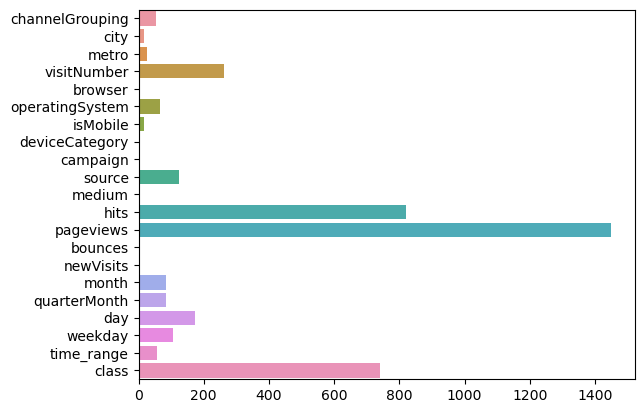

In [19]:
# feature importance
sns.barplot(x = list(reg_lgb.feature_importances_), y = list(reg_lgb.feature_name_))

Resultados

In [20]:
print('Resultados:')

print(f'Los hiperparámetros son: {reg_lgb.get_params()}')
print(f'El rmse es: {lgb_rmse:.2f}')
print(f'El r2 es: {lgb_r2:.2f}')
print(f'El r2 ajustado es: {lgb_r2_adj:.2f}')

Resultados:
Los hiperparámetros son: {'boosting_type': 'dart', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.03, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 800, 'verbosity': -1}
El rmse es: 13.89
El r2 es: 0.32
El r2 ajustado es: 0.31


Guardamos

In [21]:
# Guardamos el modelo LGBM
dump(clf_lgb, 'clasificador_lgb.joblib')
dump(reg_lgb, 'regresor_lgb_1.joblib')

['regresor_lgb_1.joblib']

---

---

In [29]:
raise ValueError('HASTA AQUI, EL RESTO ES PRUEBA')

ValueError: HASTA AQUI, EL RESTO ES PRUEBA

---
---

#### Ingenieria

* **Transformacion de Variables**

In [30]:
data = df.copy()

In [33]:
data.nunique().loc[data.nunique() > 2]

channelGrouping         8
city                  296
metro                  53
visitNumber            50
browser                22
operatingSystem        12
deviceCategory          3
campaign                7
source                 76
medium                  7
hits                   96
pageviews              75
transactionRevenue    147
month                  12
quarterMonth            4
day                    31
weekday               366
time_range              5
dtype: int64

In [34]:
# Tratamiento de datos adicional, estandarizando las variables numericas con z-score
scaler = StandardScaler()

transactionRevenue = data['transactionRevenue']
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[num_cols] = scaler.fit_transform(data[num_cols])
data['transactionRevenue'] = transactionRevenue

In [35]:
clf_lgb = lbgclass(data=data)

Precisión del clasificador: 0.988


In [36]:
reg_lgb, reg_lgb_pred, lgb_rmse, lgb_r2, lgb_r2_adj = lgbreg(data=data)

Raiz del error para el regresor: 0.707


<AxesSubplot: >

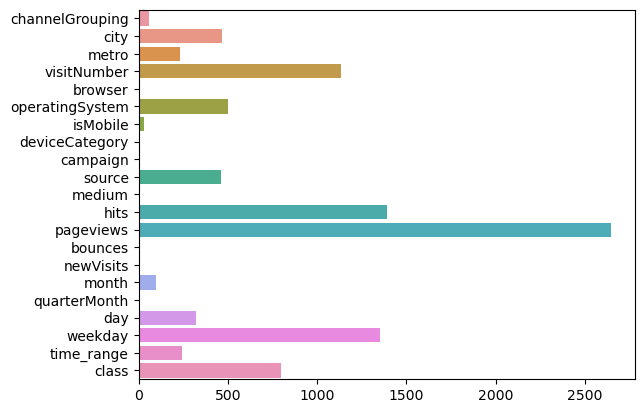

In [37]:
# feature importance
sns.barplot(x = list(reg_lgb.feature_importances_), y = list(reg_lgb.feature_name_))

Resultados

In [38]:
print('Resultados:')

print(f'Los hiperparámetros son: {reg_lgb.get_params()}')
print(f'El rmse es: {lgb_rmse:.2f}')
print(f'El r2 es: {lgb_r2:.2f}')
print(f'El r2 ajustado es: {lgb_r2_adj:.2f}')

Resultados:
Los hiperparámetros son: {'boosting_type': 'dart', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'num_boost_round': 800, 'verbosity': -1}
El rmse es: 0.71
El r2 es: 0.23
El r2 ajustado es: 0.22


In [ ]:
# Guardamos el modelo LGBM
dump(reg_lgb, 'regresor_lgb_3.joblib')

---
---